# Предсказание оттока абонентов

Ваша задача в качестве аналитика как можно точнее предсказать, откажется ли абонент от услуг компании на следующий месяц. В данной задаче вам нужно предсказать вероятность отказа, то есть вывести вещественное число на промежутке от 0 до 1 для каждого абонента из тестового набора.


Метрикой качества в задаче является ROC-AUC.

In [46]:
# с XGBoost у sklearn конфликт версий, откатываемся назад
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 42.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


Вам дано три файла: тренировочные данные (train.csv), тестовые данные (test.csv) и пример файла с решением (sample_submission.csv). Ваша цель для каждого абонента предсказать колонку Leave_Next_Month которая есть в тренировочном файле, но отсутствует в тестовом файле. Значение должно находится на промежутке от 0 до 1, где 0 - абонент точно не уйдет в следующем месяце, а 1 - абонент точно уйдет в следующем месяце.

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
!pip install catboost -q

In [5]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
from google.colab import drive
drive.mount('/content/drive')
train_link = 'drive/MyDrive/Colab_Notebooks/data/sii_data/sii_1_train.csv'
test_link = 'drive/MyDrive/Colab_Notebooks/data/sii_data/sii_1_test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
train = pd.read_csv(train_link)
test = pd.read_csv(test_link)

## Подготовка и изучение данных

In [8]:
# посмотрим на список всех колонок
print('Columns: {}'.format(list(train.columns.values)))

Columns: ['id', 'Leave_Next_Month', 'Gender', 'Pensioner', 'Married', 'Children', 'Months_with_company', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Type_contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Payment', 'Total_Payment']


In [9]:
# посмотрим какие у нас данные
train.head(10)

,id,Leave_Next_Month,Gender,Pensioner,Married,Children,Months_with_company,Phone_Service,Multiple_Lines,Internet_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Type_contract,Paperless_Billing,Payment_Method,Monthly_Payment,Total_Payment
0,4,1,F,0,N,N,2,Y,N,Fiber optic,...,N,N,N,N,N,Per_month,Y,Check_electron,70.70,151.65
1,7,0,F,0,N,N,10,N,No_phone,DSL,...,N,N,N,N,N,Per_month,N,Check_mailed,29.75,301.9
2,8,1,F,0,Y,N,28,Y,Y,Fiber optic,...,N,Y,Y,Y,Y,Per_month,Y,Check_electron,104.80,3046.05
3,9,0,M,0,N,Y,62,Y,N,DSL,...,Y,N,N,N,N,Year-1,N,Bank_transfer_auto,56.15,3487.95
4,11,0,M,0,N,N,16,Y,N,N,...,No_internet,No_internet,No_internet,No_internet,No_internet,Year-2,N,Credit_card_auto,18.95,326.8
5,14,0,M,0,N,N,25,Y,N,Fiber optic,...,N,Y,Y,Y,Y,Per_month,Y,Check_electron,105.50,2686.05
6,16,0,F,0,N,N,52,Y,N,N,...,No_internet,No_internet,No_internet,No_internet,No_internet,Year-1,N,Check_mailed,20.65,1022.95
7,19,0,F,0,N,N,21,Y,N,Fiber optic,...,Y,Y,N,N,Y,Per_month,Y,Check_electron,90.05,1862.9
8,21,0,M,0,Y,N,12,Y,N,N,...,No_internet,No_internet,No_internet,No_internet,No_internet,Year-1,N,Bank_transfer_auto,19.80,202.25
9,23,0,F,0,Y,N,58,Y,Y,DSL,...,Y,N,Y,N,N,Year-2,Y,Credit_card_auto,59.90,3505.1


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3521 entries, 0 to 3520
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   3521 non-null   int64  
 1   Leave_Next_Month     3521 non-null   int64  
 2   Gender               3521 non-null   object 
 3   Pensioner            3521 non-null   int64  
 4   Married              3521 non-null   object 
 5   Children             3521 non-null   object 
 6   Months_with_company  3521 non-null   int64  
 7   Phone_Service        3521 non-null   object 
 8   Multiple_Lines       3521 non-null   object 
 9   Internet_Service     3521 non-null   object 
 10  Online_Security      3521 non-null   object 
 11  Online_Backup        3521 non-null   object 
 12  Device_Protection    3521 non-null   object 
 13  Tech_Support         3521 non-null   object 
 14  Streaming_TV         3521 non-null   object 
 15  Streaming_Movies     3521 non-null   o

Переведем категориальные признаки в числовые с помощью LabelEncoder. Почему-то Total_Payment имеет тип object, его просто преобразуем в float.

In [11]:
object_column_list=['Gender', 'Married', 'Children', 'Phone_Service', 'Multiple_Lines', 'Internet_Service',
                    'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support',
                    'Streaming_TV', 'Streaming_Movies', 'Type_contract', 'Paperless_Billing',
                    'Payment_Method', ]

In [12]:
for item in object_column_list:
    le = LabelEncoder().fit(list(train[item].values) + list(test[item].values))
    train[item] = le.transform(train[item].values)
    test[item] = le.transform(test[item].values)

При попытке сходу преобразовать Total_Payment в числовые значения прилетает ошибка ValueError: could not convert string to float: ' '. Пропусков как таковых нет, но есть строки, значением которых является один пробел. Заполним нулями, видимо предполагалось, что клиент еще ничего не платил.

In [13]:
train['Total_Payment'] = train['Total_Payment'].astype(float)
test['Total_Payment'] = test['Total_Payment'].astype(float)

ValueError: could not convert string to float: ' '

In [14]:
missing_train = train['Total_Payment'].isnull().sum()
missing_test = test['Total_Payment'].isnull().sum()

print(f"Количество пропусков в train: {missing_train}")
print(f"Количество пропусков в test: {missing_test}")

Количество пропусков в train: 0
Количество пропусков в test: 0


In [15]:
train['Total_Payment'] = pd.to_numeric(train['Total_Payment'], downcast="float", errors="coerce").fillna(0.0)
test['Total_Payment'] = pd.to_numeric(test['Total_Payment'], downcast="float", errors="coerce").fillna(0.0)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3521 entries, 0 to 3520
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   3521 non-null   int64  
 1   Leave_Next_Month     3521 non-null   int64  
 2   Gender               3521 non-null   int64  
 3   Pensioner            3521 non-null   int64  
 4   Married              3521 non-null   int64  
 5   Children             3521 non-null   int64  
 6   Months_with_company  3521 non-null   int64  
 7   Phone_Service        3521 non-null   int64  
 8   Multiple_Lines       3521 non-null   int64  
 9   Internet_Service     3521 non-null   int64  
 10  Online_Security      3521 non-null   int64  
 11  Online_Backup        3521 non-null   int64  
 12  Device_Protection    3521 non-null   int64  
 13  Tech_Support         3521 non-null   int64  
 14  Streaming_TV         3521 non-null   int64  
 15  Streaming_Movies     3521 non-null   i

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   3522 non-null   int64  
 1   Gender               3522 non-null   int64  
 2   Pensioner            3522 non-null   int64  
 3   Married              3522 non-null   int64  
 4   Children             3522 non-null   int64  
 5   Months_with_company  3522 non-null   int64  
 6   Phone_Service        3522 non-null   int64  
 7   Multiple_Lines       3522 non-null   int64  
 8   Internet_Service     3522 non-null   int64  
 9   Online_Security      3522 non-null   int64  
 10  Online_Backup        3522 non-null   int64  
 11  Device_Protection    3522 non-null   int64  
 12  Tech_Support         3522 non-null   int64  
 13  Streaming_TV         3522 non-null   int64  
 14  Streaming_Movies     3522 non-null   int64  
 15  Type_contract        3522 non-null   i

Все данные представлены в числовом виде. Посмотрим на распределение классов и матрицу корреляций.  

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-19-0ec84ea5ef6a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='Leave_Next_Month', palette='viridis')


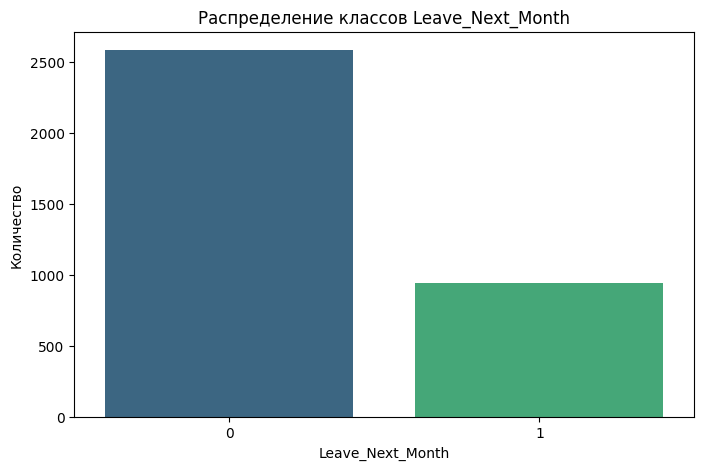

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(data=train, x='Leave_Next_Month', palette='viridis')
plt.title('Распределение классов Leave_Next_Month')
plt.xlabel('Leave_Next_Month')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

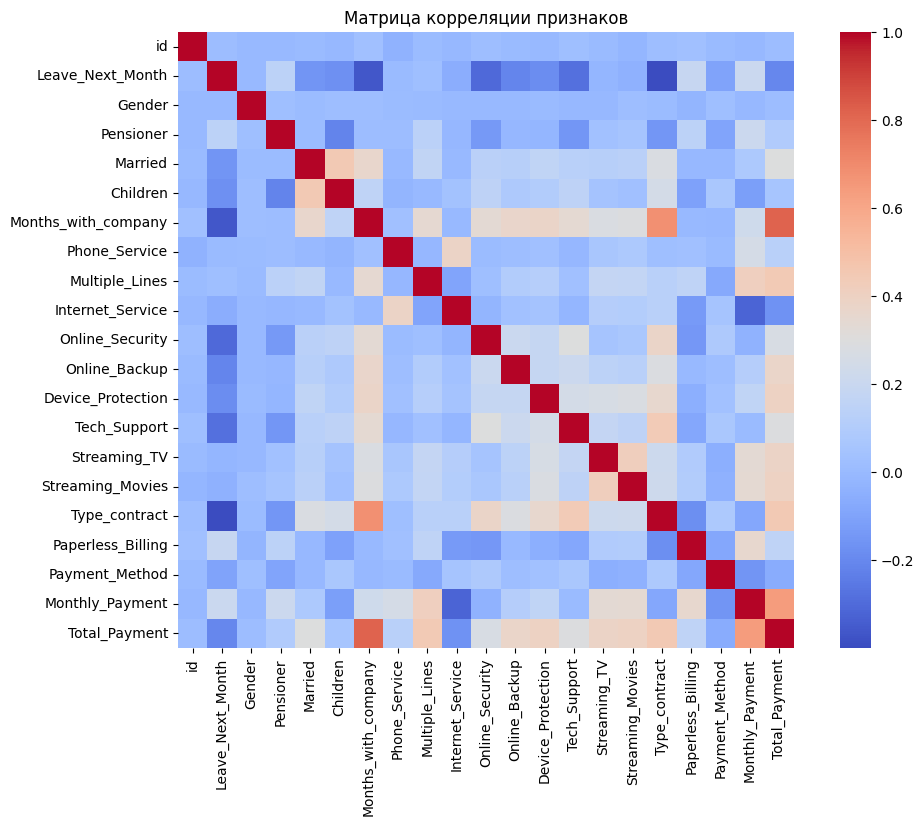

In [20]:
correlation_matrix = train.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, cbar=True)
plt.title('Матрица корреляции признаков')
plt.show()

Уже сходу можно сказать, что чем больше у человека куплено дополнительных услуг, тем менее вероятен его уход от компании. Также чем больше месяцев он является клиентом компании, тем больше у него приобретено дополнительных услаг, и естественно тем больше общая сумма оплаты.

## Тестирование моделей

Удалим бесполезную колонку id и разделим данные на тренировочные и валидационные.

In [21]:
train = train.drop(columns = ['id'])
test = test.drop(columns = ['id'])

In [22]:
X = train.drop(columns=['Leave_Next_Month'])
y = train['Leave_Next_Month']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Сравнение LightGBM, XGBoost, CatBoost

Сначала сравним все три библиотеки на одинх и тех же параметрах

In [23]:
from sklearn.metrics import classification_report, roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [24]:
def evaluate_model(model, X_val, y_val):
    """Вычисление ключевых метрик"""
    probs = model.predict_proba(X_val)[:, 1]
    preds = model.predict(X_val)

    print(f"ROC-AUC: {roc_auc_score(y_val, probs):.4f}")
    print(classification_report(y_val, preds))

In [25]:
# Базовые параметры для всех моделей
common_params = {
    'learning_rate': 0.1,
    'n_estimators': 200,
    'max_depth': 5,
    'random_state': 42
}

# Инициализация моделей
models = {
    'LightGBM': LGBMClassifier(**common_params, verbose=-1),
    'XGBoost': XGBClassifier(**common_params, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(**common_params, verbose=0)
}

In [26]:
# Обучение и оценка
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    evaluate_model(model, X_val, y_val)


=== LightGBM ===
ROC-AUC: 0.8323
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       534
           1       0.59      0.54      0.56       171

    accuracy                           0.80       705
   macro avg       0.72      0.71      0.71       705
weighted avg       0.79      0.80      0.79       705


=== XGBoost ===
ROC-AUC: 0.8427
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       534
           1       0.61      0.57      0.59       171

    accuracy                           0.81       705
   macro avg       0.74      0.73      0.73       705
weighted avg       0.80      0.81      0.81       705


=== CatBoost ===
ROC-AUC: 0.8436
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       534
           1       0.61      0.55      0.58       171

    accuracy                           0.81       705
   macro avg       0.74    

Видно, что LIghtGBM показывает худшие метрики, XGBoost чуть лучше, а CatBoost лучше всех. Тем не менее разница во всех метриках не превосходит нескольких сотых, разница не принципиальная.

### Подбор лучших параметров для моделей

Попробуем подобрать параметры получше, может быть метрики возрастут

In [27]:
# LightGBM
lgb_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbose=-1)
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}
grid_search_lgb = GridSearchCV(lgb_model, param_grid, cv=3, scoring='roc_auc')
grid_search_lgb.fit(X_train, y_train)
best_model_lgb = grid_search_lgb.best_estimator_

evaluate_model(best_model_lgb, X_val, y_val)

ROC-AUC: 0.8475
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       534
           1       0.67      0.53      0.59       171

    accuracy                           0.82       705
   macro avg       0.76      0.72      0.74       705
weighted avg       0.81      0.82      0.82       705



In [38]:
# XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}
grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=3, scoring='roc_auc')
grid_search_xgb.fit(X_train, y_train)
best_model_xgb = grid_search_xgb.best_estimator_

evaluate_model(best_model_xgb, X_val, y_val)

ROC-AUC: 0.8602
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       534
           1       0.65      0.54      0.59       171

    accuracy                           0.82       705
   macro avg       0.76      0.72      0.74       705
weighted avg       0.81      0.82      0.81       705



In [29]:
# CatBoost
cat_model = CatBoostClassifier(loss_function='Logloss', verbose=0)
param_grid = {
    'depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 200, 300]
}
grid_search_cat = GridSearchCV(cat_model, param_grid, cv=3, scoring='roc_auc')
grid_search_cat.fit(X_train, y_train)
best_model_cat = grid_search_cat.best_estimator_

evaluate_model(best_model_cat, X_val, y_val)

ROC-AUC: 0.8567
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       534
           1       0.63      0.54      0.58       171

    accuracy                           0.81       705
   macro avg       0.74      0.72      0.73       705
weighted avg       0.80      0.81      0.81       705



В целом метрики возросли, но очень немного. После перебора параметров вперед вырвался XGBoost. Опять же, разница с CatBoost в ROC-AUC составляет 0.0035, на уровне погрешности. LGBM отстает более значительно, на 0.127.  Стоит однако отметить, что лучший f1-score равен 0.59, что в реальных условиях может оказаться слишком низким результатом. Возможно, нужно создание синтетических фичей, либо более тонкая настройка моделей.